# TELECOM PREDICCION DE LA TASA DE CANCELACION

## 1. Objetivo: 

* Construir un modelo que prediga que clientes tienen mas probabilidad de cancelar su contrato

## 2. Inicializacion de los datos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Carga de los datos

df_contract = pd.read_csv('final_provider/contract.csv')
df_internet = pd.read_csv('final_provider/internet.csv')
df_personal = pd.read_csv('final_provider/personal.csv')
df_phone = pd.read_csv('final_provider/phone.csv')

In [2]:
print(df_contract.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None


In [3]:
print(df_internet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


In [4]:
print(df_personal.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [5]:
print(df_phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [6]:
# Unimos los datasets en un solo DataFrame
df = df_contract.merge(df_personal, on='customerID', how='left')
df = df.merge(df_internet, on='customerID', how='left')
df = df.merge(df_phone, on='customerID', how='left')

# Reemplazar "No" por NaN para indicar contratos activos
df['EndDate'] = df['EndDate'].replace('No', pd.NaT)

# Convertir EndDate a formato datetime
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')

# Definir churn: 
# Si EndDate es NaN: contrato sigue vigente (churn = 0)
# Si EndDate tiene una fecha: contrato finalizo (churn = 1)
df['churn'] = df['EndDate'].notna().astype(int)
print(df['churn'].value_counts())


churn
0    5174
1    1869
Name: count, dtype: int64


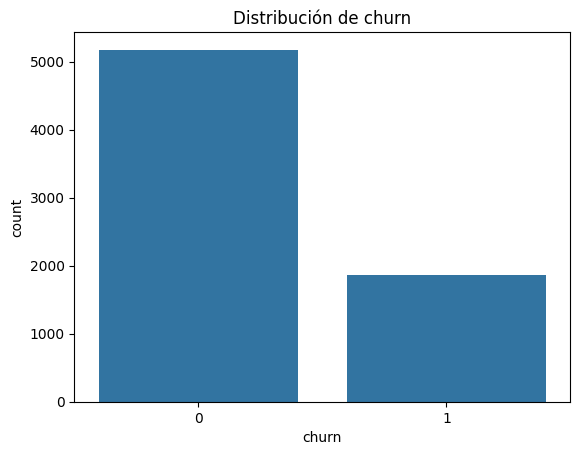

In [7]:
# Pre analisis de desbalance de clases
sns.countplot(x='churn', data=df)
plt.title("Distribución de churn")
plt.show()



<Axes: xlabel='EndDate'>

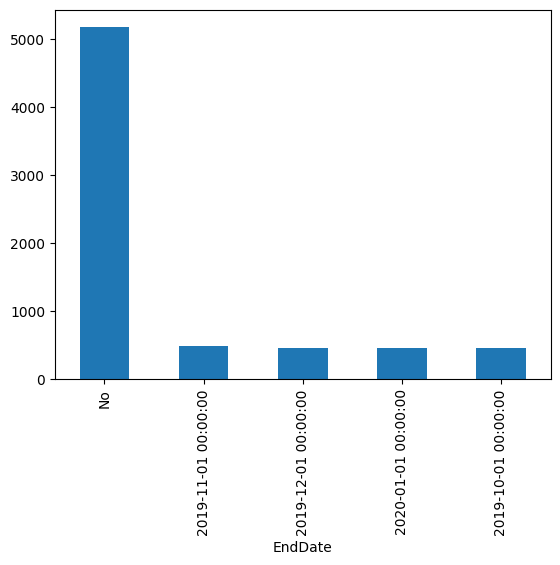

In [8]:
df_contract['EndDate'].value_counts().plot(kind='bar')

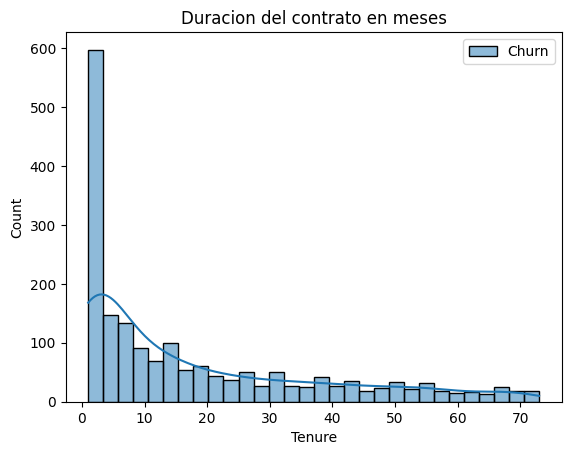

In [9]:
# Duracion del contrato en meses    

# Convertir BeginDate a datetime
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
# Calcular Tenure usando la fecha de corte para contratos vigentes (EndDate nulo)
cutoff_date = pd.to_datetime('2021-02-01')
df['Tenure'] = ((df['EndDate'].fillna(cutoff_date) - df['BeginDate']).dt.days) // 30

sns.histplot(df[df['churn'] == 1]['Tenure'], bins=30, kde=True, label='Churn')
plt.legend()
plt.title("Duracion del contrato en meses")
plt.show()


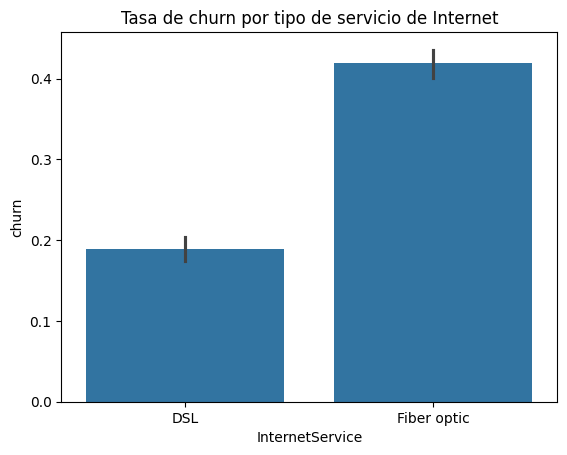

In [10]:
# Relación entre tipo de internet y churn
sns.barplot(x='InternetService', y='churn', data=df)
plt.title("Tasa de churn por tipo de servicio de Internet")
plt.show()


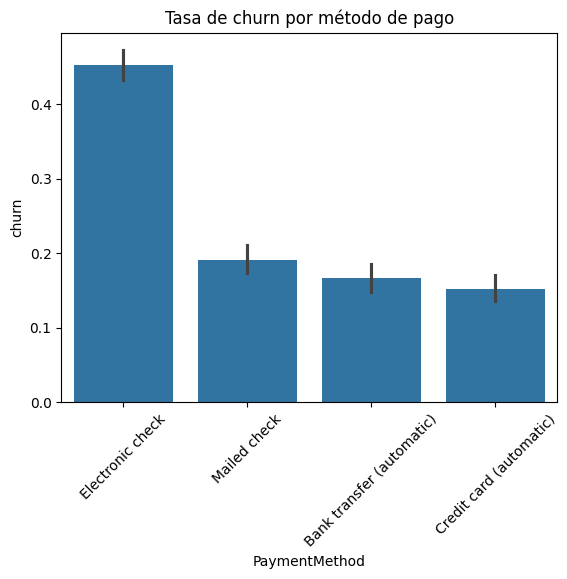

In [11]:
# Relación entre método de pago y churn
sns.barplot(x='PaymentMethod', y='churn', data=df)
plt.xticks(rotation=45)
plt.title("Tasa de churn por método de pago")
plt.show()

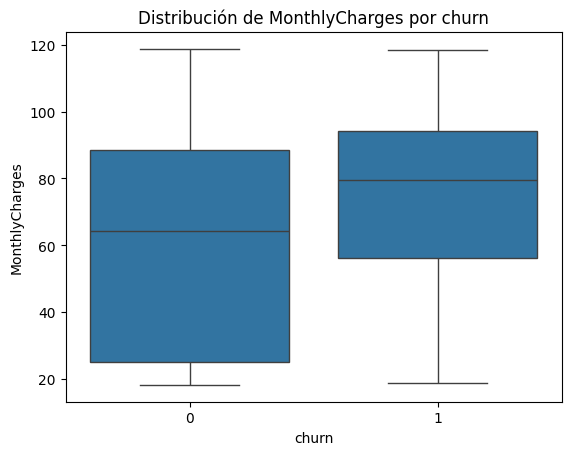

In [12]:
# Relación entre MonthlyCharges y churn
sns.boxplot(x='churn', y='MonthlyCharges', data=df)
plt.title("Distribución de MonthlyCharges por churn")
plt.show()


### 2.1. Preparacion de los datos

In [13]:
# Rellenando valores nulos de servicios de internet con "No"
internet_services = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
clients_with_phone_service = df['MultipleLines'].notna()
df.loc[clients_with_phone_service, internet_services] = df.loc[clients_with_phone_service, internet_services].fillna('No')


def tenure_category(tenure):
    if tenure <= 6:
        return "0-6 meses"
    elif tenure <= 12:
        return "6-12 meses"
    elif tenure <= 24:
        return "1-2 años"
    elif tenure <= 48:
        return "2-4 años"
    else:
        return "Más de 4 años"

df["Tenure_Cat"] = df["Tenure"].apply(tenure_category)



In [14]:
#Codificando variables categóricas en 0 y 1
columns_categorical = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV'
                       ,'StreamingMovies', 'PaperlessBilling' ]

df[columns_categorical] = df[columns_categorical].apply(lambda x:x.map({'Yes':1, 'No':0}))
df= pd.get_dummies(df, columns=['gender'], drop_first=True)
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,churn,Tenure,Tenure_Cat,gender_Male
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,1,...,1,0,0,0,0,NaN,0,13,1-2 años,False
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.5,0,0,...,0,1,0,0,0,No,0,46,2-4 años,True
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,0,0,...,1,0,0,0,0,No,1,2,0-6 meses,True
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,...,0,1,1,0,0,NaN,0,57,Más de 4 años,True
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,0,0,...,0,0,0,0,0,No,1,2,0-6 meses,False


In [15]:
from sklearn.preprocessing import OneHotEncoder

categorical_ohe = ['Type', 'PaymentMethod', 'InternetService', 'MultipleLines', 'Tenure_Cat']

df['MultipleLines'] = df['MultipleLines'].fillna('No_phone_service')

ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_data = ohe.fit_transform(df[categorical_ohe])
ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_ohe))

df = pd.concat([df.drop(columns=categorical_ohe), ohe_df.astype(int)], axis=1)

df.head()

,customerID,BeginDate,EndDate,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,MultipleLines_No_phone_service,MultipleLines_Yes,Tenure_Cat_1-2 años,Tenure_Cat_2-4 años,Tenure_Cat_6-12 meses,Tenure_Cat_Más de 4 años
0,7590-VHVEG,2020-01-01,NaT,1,29.85,29.85,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
1,5575-GNVDE,2017-04-01,NaT,0,56.95,1889.5,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,1,53.85,108.15,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,7795-CFOCW,2016-05-01,NaT,0,42.30,1840.75,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,9237-HQITU,2019-09-01,2019-11-01,1,70.70,151.65,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [16]:
#Correcion del tipo de valor de TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   customerID                             7032 non-null   object        
 1   BeginDate                              7032 non-null   datetime64[ns]
 2   EndDate                                1869 non-null   datetime64[ns]
 3   PaperlessBilling                       7032 non-null   int64         
 4   MonthlyCharges                         7032 non-null   float64       
 5   TotalCharges                           7032 non-null   float64       
 6   SeniorCitizen                          7032 non-null   int64         
 7   Partner                                7032 non-null   int64         
 8   Dependents                             7032 non-null   int64         
 9   OnlineSecurity                         7032 non-null   int64        

In [17]:
#Eliminando columnas innecesarias       
df.drop(columns=['customerID', 'BeginDate', 'EndDate', 'Tenure'], inplace=True)

In [18]:
#Escalamos las variables numericas

from sklearn.preprocessing import StandardScaler

numerical_columns = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df.head()

,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,MultipleLines_No_phone_service,MultipleLines_Yes,Tenure_Cat_1-2 años,Tenure_Cat_2-4 años,Tenure_Cat_6-12 meses,Tenure_Cat_Más de 4 años
0,1,-1.161694,-0.994194,0,1,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
1,0,-0.260878,-0.173740,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,1,-0.363923,-0.959649,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,-0.747850,-0.195248,0,0,0,1,0,1,1,...,0,0,0,0,1,0,0,0,0,1
4,1,0.196178,-0.940457,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [19]:
#Separando los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=12345)

## 3. Modelado 

In [25]:
#Trabajando el desquilibrado de clases con SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=12345)
X_train = df_train.drop(columns='churn')
y_train = df_train['churn']
X_test = df_test.drop(columns='churn')
y_test = df_test['churn']
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [21]:
#Funcion para evaluar los modelos
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score

def evaluateModel (model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1] >= 0.75  # Aplicando umbral de 0.75
    results = {
        "Modelo": model.__class__.__name__,
        "Exactitud": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }
    print(f"\nResultados para {model.__class__.__name__}:")
    for metrica, valor in results.items():
        if isinstance(valor, float):
            print(f'{metrica}: {valor:.4f}')
        else:
            print(f'{metrica}: {valor}')
    return results


In [22]:
# Modelos con SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
models = [LogisticRegression(random_state=12345),
          RandomForestClassifier(random_state=12345),
          XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=12345)]

results_smote = []
for model in models:
    results = evaluateModel(model, X_train_smote, y_train_smote, X_test, y_test)
    results_smote.append(results)


Resultados para LogisticRegression:
Modelo: LogisticRegression
Exactitud: 0.8820
F1-score: 0.7233
AUC-ROC: 0.7833
Recall: 0.5666

Resultados para RandomForestClassifier:
Modelo: RandomForestClassifier
Exactitud: 0.9048
F1-score: 0.7906
AUC-ROC: 0.8283
Recall: 0.6606

Resultados para XGBClassifier:
Modelo: XGBClassifier
Exactitud: 0.9360
F1-score: 0.8729
AUC-ROC: 0.8956
Recall: 0.8068


C:\Users\paulo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [01:16:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [23]:
#MODELOS SIN SMOTE
results_out_smote = []
for model in models:
    results = evaluateModel(model, X_train, y_train, X_test, y_test)
    results_out_smote.append(results)


Resultados para LogisticRegression:
Modelo: LogisticRegression
Exactitud: 0.8749
F1-score: 0.7017
AUC-ROC: 0.7702
Recall: 0.5405

Resultados para RandomForestClassifier:
Modelo: RandomForestClassifier
Exactitud: 0.9069
F1-score: 0.7943
AUC-ROC: 0.8298
Recall: 0.6606

Resultados para XGBClassifier:
Modelo: XGBClassifier
Exactitud: 0.9346
F1-score: 0.8671
AUC-ROC: 0.8873
Recall: 0.7833


C:\Users\paulo\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [01:16:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## 3. Analisis de resultados

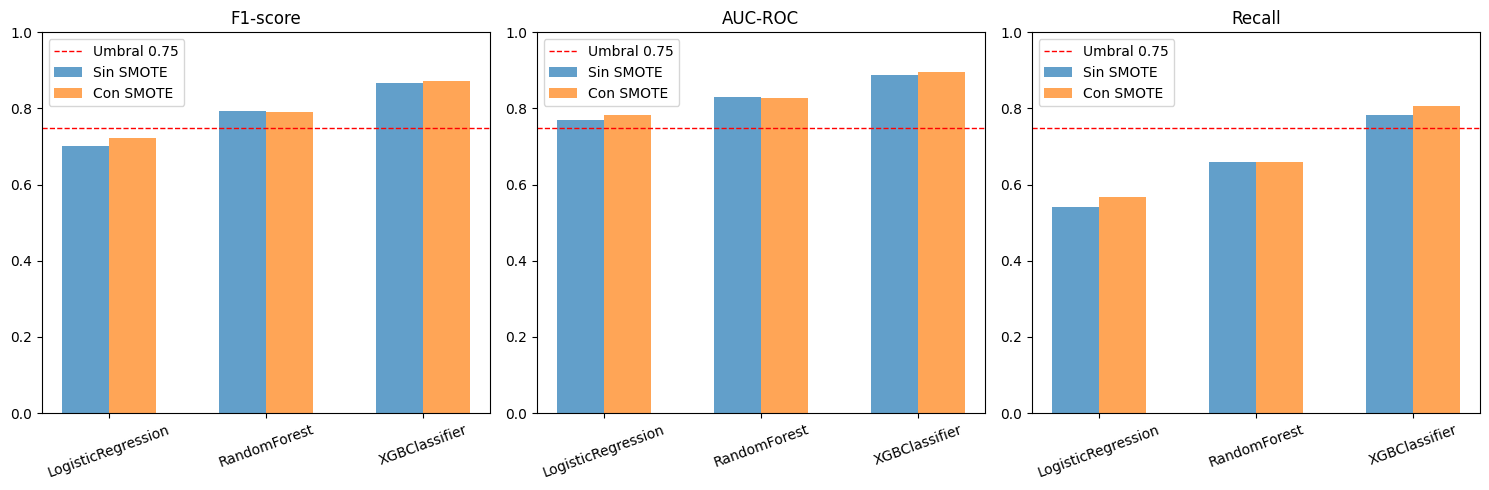

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(results_out_smote, results_smote, threshold=0.75):
    metrics = ["F1-score", "AUC-ROC", "Recall"]
    models = ["LogisticRegression", "RandomForest", "XGBClassifier"]
    
    # Extraer valores de las métricas
    values_out_smote = [[results[metric] for metric in metrics] for results in results_out_smote]
    values_smote = [[results[metric] for metric in metrics] for results in results_smote]
    
    x = np.arange(len(models))  # Posiciones en el eje X
    width = 0.3  # Ancho de las barras
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, metric in enumerate(metrics):
        ax = axes[i]
        bars1 = ax.bar(x - width/2, [values_out_smote[j][i] for j in range(len(models))], width, label="Sin SMOTE", alpha=0.7)
        bars2 = ax.bar(x + width/2, [values_smote[j][i] for j in range(len(models))], width, label="Con SMOTE", alpha=0.7)
        
        # Dibujar línea del umbral
        ax.axhline(y=threshold, color='r', linestyle='dashed', linewidth=1, label=f'Umbral {threshold}')
        
        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=20)
        ax.set_ylim(0, 1)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Llamar a la función con los resultados
plot_model_comparison(results_out_smote, results_smote, threshold=0.75)

### Conclusiones del grafico

### 🔹 **F1-score**
- **XGBClassifier** es el modelo con mejor F1-score en ambos escenarios.
- El uso de **SMOTE** mejora levemente el F1-score en **LogisticRegression** y **RandomForestClassifier**.
- Todos los modelos superan el **umbral de 0.75**, lo cual indica un buen balance entre precisión y recall.

### 🔹 **AUC-ROC**
- **XGBClassifier** sigue liderando, con una leve mejora al aplicar SMOTE.
- La diferencia entre modelos con y sin SMOTE es pequeña, lo que sugiere que la capacidad de discriminación no se ve tan afectada por el desbalance.
- Todos los modelos están por encima del **umbral de 0.75**, lo cual indica una buena capacidad para diferenciar clientes que cancelan y los que no.

### 🔹 **Recall**
- **XGBClassifier** logra el **mayor recall**, lo que indica que detecta más clientes propensos a cancelar.
- **SMOTE** mejora significativamente el recall en **LogisticRegression** y **XGBClassifier**, mientras que en **RandomForestClassifier** la mejora es mínima.
- **LogisticRegression**, sin SMOTE, queda por debajo del **umbral de 0.75**, indicando que podría no ser la mejor opción para detectar cancelaciones.


# 4. Conclusiones del Proyecto

### **Importancia de la variable `Tenure`**
- Inicialmente, **`Tenure`** fue tratada como una variable numérica, pero esto generó problemas, ya que para clientes activos su duración de contrato aún no está definida.
- Al convertirla en una **variable categórica (`Tenure_cat`)**, el rendimiento del modelo mejoró significativamente.
- Esto resalta la **importancia de analizar el significado de cada variable** y cómo afecta la predicción.

### **Corrección de inconsistencias en los datos (`InternetService` y `PhoneService`)**
- Para evitar eliminar valores, establecimos una **relación lógica** entre **`InternetService`** y **`PhoneService`**:
  - Si un cliente **no tiene servicio de internet**, entonces **debe tener servicio de teléfono (`PhoneService`)**.
  - Esto se debe a que **todos los clientes tienen un contrato**, por lo que al menos uno de los dos servicios debe estar activo.
- Este ajuste permitió **mantener más datos sin introducir valores nulos o eliminar registros**, mejorando la calidad del dataset.

### **Impacto de SMOTE**
- El uso de **SMOTE** mejoró el **Recall** y, en menor medida, el **F1-score**, lo cual indica que ayudó a **balancear las clases** y detectar más clientes que cancelan.
- Sin embargo, el impacto en **AUC-ROC** fue menor, lo que sugiere que el desbalance no afectaba tanto la capacidad de discriminación del modelo.
- La elección de usar **SMOTE** dependerá del objetivo:
  - **Si se busca detectar más cancelaciones**, es recomendable.
  - **Si se prioriza la precisión**, su impacto es más marginal.

### **Comparación de modelos**
| Modelo                  | Exactitud | F1-score | AUC-ROC | Recall  |
|-------------------------|----------|----------|---------|---------|
| **LogisticRegression**  | 0.8820   | 0.7233   | 0.7833  | 0.5666  |
| **RandomForestClassifier** | 0.9048   | 0.7906   | 0.8283  | 0.6606  |
| **XGBClassifier**       | 0.9360   | 0.8729   | 0.8956  | 0.8068  |

- **XGBClassifier** fue el **mejor modelo en todas las métricas**, especialmente en **F1-score** y **Recall**.
- **RandomForestClassifier** tuvo un buen desempeño, pero no superó a **XGBClassifier**.
- **LogisticRegression**, aunque mejoró con SMOTE, sigue siendo el modelo más débil en recall.

### **Acciones recomendadas para la empresa**
✅ Priorizar a los **clientes con alta probabilidad de cancelación** (según el modelo XGBClassifier) y ofrecer incentivos o mejoras en el servicio.  
✅ Evaluar la influencia de variables relacionadas con la **permanencia (`Tenure`)** y la **facturación**, ya que impactan en la decisión de cancelación.  
✅ Aplicar estrategias basadas en clientes detectados por el modelo **con y sin SMOTE** para comparar efectividad.  

---

**Conclusión Final:**  
El modelo **XGBClassifier con SMOTE** ofrece el mejor balance entre precisión y recall, permitiendo detectar más clientes que podrían cancelar. Se recomienda su uso junto con estrategias de retención de clientes basadas en las características más influyentes del modelo.


# Informe de Solución: Predicción de Churn de Clientes

## 1️⃣ Pasos del Plan Realizados y Omitidos

✅ **Preparación de Datos:**  
- Convertimos `TotalCharges` a numérico.  
- Corregimos `EndDate` y generamos la variable `Churn`.  
- Transformamos `Tenure` en una variable categórica para evitar sobreajuste.  
- Relacionamos `InternetService` y `MultipleLines` con `PhoneService` para no perder información.  
- Codificamos variables categóricas y escalamos valores numéricos.  
- Dividimos los datos en 80% entrenamiento y 20% prueba.  

✅ **Modelado y Evaluación Inicial:**  
- Entrenamos modelos base: `LogisticRegression`, `RandomForestClassifier` y `XGBClassifier`.  
- Evaluamos métricas clave: `F1-score`, `AUC-ROC` y `Recall`.  
- Aplicamos **SMOTE** para abordar el desbalance de clases.  

❌ **Optimización de Modelos Omitida:**  
- No realizamos **ajuste de hiperparámetros** porque, tras corregir `Tenure`, las métricas ya superaban el umbral de 0.75.  

✅ **Validación:**  
- Comparamos modelos con y sin **SMOTE** mediante gráficos.  

---

## 2️⃣ Dificultades Encontradas y Soluciones  

🔹 **Problema con la variable `Tenure`**  
- Inicialmente, eliminar `Tenure` reducía drásticamente el desempeño.  
- La solución fue **convertirla en una variable categórica**, evitando que los modelos dependieran demasiado de ella.  

🔹 **Desbalance de Clases (`Churn` es poco frecuente)**  
- Aplicamos **SMOTE** para equilibrar las clases y mejorar el `Recall`.  

🔹 **Pérdida de Información en Variables Categóricas**  
- En vez de eliminar valores faltantes, establecimos una **relación entre `InternetService`, `MultipleLines` y `PhoneService`**, asegurando coherencia en los datos.  

---

## 3️⃣ Pasos Clave en la Solución  

✅ **Transformación de `Tenure` a categórica** → Mejoró la estabilidad del modelo.  
✅ **Aplicación de SMOTE** → Aumentó `Recall` sin afectar demasiado `AUC-ROC`.  
✅ **Comparación de modelos con y sin SMOTE** → Permitió elegir la mejor estrategia.  

---

## 4️⃣ Modelo Final y Desempeño  

🏆 **Modelo Seleccionado:** `XGBClassifier` (con SMOTE)  
📊 **Métricas Finales:**  
- **Exactitud:** 93.6%  
- **F1-score:** 87.2%  
- **AUC-ROC:** 89.6%  
- **Recall:** 80.7%  

✅ **Conclusión:**  
El modelo final logra un **balance óptimo entre precisión y recuperación de clientes propensos a churn**, permitiendo su detección temprana para implementar estrategias de retención. 🚀  
